In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             f1_score, roc_auc_score, roc_curve, auc, make_scorer)

from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE



## 1. Load Data & Merged Data

In [699]:
songs_labeled = pd.read_csv('songs_aggregated_labeled.csv', sep=';')

songs_labeled['first_appearance'] = pd.to_datetime(songs_labeled['first_appearance'])
songs_labeled['last_appearance'] = pd.to_datetime(songs_labeled['last_appearance'])

print(f"  Total songs: {len(songs_labeled):,}")
print(f"  Training:    {songs_labeled['is_train'].sum():,}")
print(f"  Test:        {(~songs_labeled['is_train']).sum():,}")

songs_labeled.head()

  Total songs: 9,161
  Training:    7,572
  Test:        1,589


,id,best_rank,avg_rank,total_weeks_charted,first_appearance,last_appearance,Title,Artist,peak_score,longevity_score,popularity_score,popularity_label,is_train
0,000xQL6tZNLJzIrtIgxqSl,40,101.500000,118,2017-03-24,2017-09-12,Still Got Time (feat. PARTYNEXTDOOR),ZAYN,80.5,100.0,92.2,Popular,True
1,003VDDA7J3Xb2ZFlNx7nIZ,108,138.000000,2,2020-02-07,2020-02-08,YELL OH,Trippie Redd,46.5,10.0,24.6,Not Popular,True
2,003eoIwxETJujVWmNFMoZy,91,136.500000,14,2018-06-15,2018-06-28,Growing Pains,Alessia Cara,55.0,70.0,64.0,Not Popular,True
3,003vvx7Niy0yvhvHt4a68B,73,173.794872,273,2020-08-15,2021-12-31,Mr. Brightside,The Killers,64.0,100.0,85.6,Popular,True
4,00B7TZ0Xawar6NZ00JFomN,61,109.285714,14,2018-04-06,2018-04-19,Best Life (feat. Chance The Rapper),Cardi B,70.0,70.0,70.0,Not Popular,True


In [700]:
df_song_charts = pd.read_csv("final_cleaned_data.csv", sep=';')
df_song_charts['Date'] = pd.to_datetime(df_song_charts['Date'])
audio_features = df_song_charts.groupby('id')[['Danceability', 'Energy', 'Loudness_norm', 
                                                    'Speechiness', 'Acousticness', 
                                                    'Instrumentalness',  'Valence'
                                                    ]].first().reset_index()

In [701]:
merged_df_spotify = songs_labeled.merge(audio_features, on='id', how='inner')
merged_df_spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9161 entries, 0 to 9160
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   9161 non-null   object        
 1   best_rank            9161 non-null   int64         
 2   avg_rank             9161 non-null   float64       
 3   total_weeks_charted  9161 non-null   int64         
 4   first_appearance     9161 non-null   datetime64[ns]
 5   last_appearance      9161 non-null   datetime64[ns]
 6   Title                9161 non-null   object        
 7   Artist               9161 non-null   object        
 8   peak_score           9161 non-null   float64       
 9   longevity_score      9161 non-null   float64       
 10  popularity_score     9161 non-null   float64       
 11  popularity_label     9161 non-null   object        
 12  is_train             9161 non-null   bool          
 13  Danceability         9161 non-nul

In [702]:
merged_df_spotify['release_year'] = merged_df_spotify['first_appearance'].dt.year
merged_df_spotify['release_month'] = merged_df_spotify['first_appearance'].dt.month
merged_df_spotify['release_quarter'] = merged_df_spotify['first_appearance'].dt.quarter
merged_df_spotify['release_day_of_week'] = merged_df_spotify['first_appearance'].dt.dayofweek
merged_df_spotify['chart_lifespan_days'] = (merged_df_spotify['last_appearance'] - merged_df_spotify['first_appearance']).dt.days

merged_df_spotify['is_holiday_season'] = (
   merged_df_spotify['release_month'].isin([11, 12])
).astype(int)

merged_df_spotify['is_friday_release'] = (
   merged_df_spotify['release_day_of_week'] == 4
).astype(int)

merged_df_spotify.head()


,id,best_rank,avg_rank,total_weeks_charted,first_appearance,last_appearance,Title,Artist,peak_score,longevity_score,...,Acousticness,Instrumentalness,Valence,release_year,release_month,release_quarter,release_day_of_week,chart_lifespan_days,is_holiday_season,is_friday_release
0,000xQL6tZNLJzIrtIgxqSl,40,101.500000,118,2017-03-24,2017-09-12,Still Got Time (feat. PARTYNEXTDOOR),ZAYN,80.5,100.0,...,0.131,0.0,0.524,2017,3,1,4,172,0,1
1,003VDDA7J3Xb2ZFlNx7nIZ,108,138.000000,2,2020-02-07,2020-02-08,YELL OH,Trippie Redd,46.5,10.0,...,0.004,0.0,0.190,2020,2,1,4,1,0,1
2,003eoIwxETJujVWmNFMoZy,91,136.500000,14,2018-06-15,2018-06-28,Growing Pains,Alessia Cara,55.0,70.0,...,0.082,0.0,0.437,2018,6,2,4,13,0,1
3,003vvx7Niy0yvhvHt4a68B,73,173.794872,273,2020-08-15,2021-12-31,Mr. Brightside,The Killers,64.0,100.0,...,0.001,0.0,0.236,2020,8,3,5,503,0,0
4,00B7TZ0Xawar6NZ00JFomN,61,109.285714,14,2018-04-06,2018-04-19,Best Life (feat. Chance The Rapper),Cardi B,70.0,70.0,...,0.287,0.0,0.665,2018,4,2,4,13,0,1


In [703]:
audio_features_cols = ['Danceability', 'Energy', 'Loudness_norm', 'Speechiness', 
                       'Acousticness', 'Instrumentalness', 'Valence']

artist_features_cols = [ 
                        'artist_song_count', 
                        'artist_avg_rank',
                        'artist_best_rank'
                        ]

temporal_features_cols = ['release_quarter',
                          'release_month', 
                          'release_day_of_week', 'is_holiday_season', 'is_friday_release']

all_features =  temporal_features_cols + audio_features_cols + artist_features_cols


In [704]:

train_years = [2017, 2018, 2019, 2020, 2021]

df_song_charts['Year'] = df_song_charts['Date'].dt.year
artist_stats_train = df_song_charts.groupby('Artist (Ind.)').agg({
    'id': 'nunique',           
    'Rank': 'min',              
    'Date': 'count'          
}).reset_index()

artist_stats_train.columns = ['Artist', 'artist_song_count', 'artist_best_rank', 'artist_total_appearances']
artist_avg_rank = df_song_charts.groupby('Artist (Ind.)')['Rank'].mean().reset_index()
artist_avg_rank.columns = ['Artist', 'artist_avg_rank']
artist_stats_train = artist_stats_train.merge(artist_avg_rank, on='Artist')
merged_df = merged_df_spotify.merge(artist_stats_train, on='Artist', how='left')




## 2. Model validation
We chose 2 different model validation method which are Train Test Split and TimeSeriesSplitter. The reason that we need to use TimeSeriesSplitter is because we don't want our model to accidentally train on future data

In [705]:
merged_df['Year'] = merged_df['first_appearance'].dt.year
train_years = [2017, 2018, 2019, 2020, 2021]
test_years = [2022, 2023]

training_merged_df = merged_df[merged_df['Year'].isin(train_years)].copy()
test_merged_df = merged_df[merged_df['Year'].isin(test_years)].copy()


X_train = training_merged_df[all_features].copy()
y_train = (training_merged_df['popularity_label'] == 'Popular').astype(int)
X_test = test_merged_df[all_features].copy()
y_test = (test_merged_df['popularity_label'] == 'Popular').astype(int)


In [706]:
skf = StratifiedKFold(n_splits=5)

## 3. Scaling

In [730]:
X_train.head(2)

,release_quarter,release_month,release_day_of_week,is_holiday_season,is_friday_release,Danceability,Energy,Loudness_norm,Speechiness,Acousticness,Instrumentalness,Valence,artist_song_count,artist_avg_rank,artist_best_rank
4295,1,1,5,0,0,0.925,0.397,0.673241,0.169,0.089,0.0,0.429,19,97.167431,4
6690,4,12,5,1,0,0.709,0.816,0.861146,0.035,0.685,0.0,0.921,3,142.583333,64


For Train Test Splitting + TimeSeriesSPlitter

In [707]:
def create_preprocessor(model_type, features):
    if model_type in ['RandomForest', 'XGBoost', 'DecisionTree']:
        return ColumnTransformer(
            [('passthrough', 'passthrough', features)]
        )
    
    elif model_type in ['KNN']:
        return ColumnTransformer([
            ('minmaxscaler', MinMaxScaler(), features) 
        ])
    else:
        return ColumnTransformer(
            [('scaler', StandardScaler(), features)]
        )

In [708]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), all_features)
    ])

## 4. Sampling

Train Test Split + Time SeriesSplitter

In [709]:
smote = SMOTE(random_state=42)


In [740]:
print(f"\n✓ Overall label distribution:")
overall_labels = training_merged_df['popularity_label'].value_counts()
for label, count in overall_labels.items():
    print(f"  {label:15s}: {count:,} ({count/len(training_merged_df)*100:.1f}%)")


✓ Overall label distribution:
  Not Popular    : 5,297 (70.0%)
  Popular        : 2,275 (30.0%)


In [751]:
X_resampled, y_resampled= smote.fit_resample(X_train, y_train)

In [752]:
print(f"Before Sampling: {X_train.shape}")
print(f"After Sampling: {X_resampled.shape}")

print("Class distribution before SMOTE:")
print(y_train.value_counts(normalize=True))
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts(normalize=True))

Before Sampling: (4537, 15)
After Sampling: (6336, 15)
Class distribution before SMOTE:
popularity_label
0    0.698259
1    0.301741
Name: proportion, dtype: float64
Class distribution after SMOTE:
popularity_label
1    0.5
0    0.5
Name: proportion, dtype: float64


In [710]:
merged_df.head(5)

,id,best_rank,avg_rank,total_weeks_charted,first_appearance,last_appearance,Title,Artist,peak_score,longevity_score,...,release_quarter,release_day_of_week,chart_lifespan_days,is_holiday_season,is_friday_release,artist_song_count,artist_best_rank,artist_total_appearances,artist_avg_rank,Year
0,000xQL6tZNLJzIrtIgxqSl,40,101.500000,118,2017-03-24,2017-09-12,Still Got Time (feat. PARTYNEXTDOOR),ZAYN,80.5,100.0,...,1,4,172,0,1,22,2,1172,92.156997,2017
1,003VDDA7J3Xb2ZFlNx7nIZ,108,138.000000,2,2020-02-07,2020-02-08,YELL OH,Trippie Redd,46.5,10.0,...,1,4,1,0,1,68,14,453,129.121413,2020
2,003eoIwxETJujVWmNFMoZy,91,136.500000,14,2018-06-15,2018-06-28,Growing Pains,Alessia Cara,55.0,70.0,...,2,4,13,0,1,8,18,420,105.028571,2018
3,003vvx7Niy0yvhvHt4a68B,73,173.794872,273,2020-08-15,2021-12-31,Mr. Brightside,The Killers,64.0,100.0,...,3,5,503,0,0,6,73,863,173.241020,2020
4,00B7TZ0Xawar6NZ00JFomN,61,109.285714,14,2018-04-06,2018-04-19,Best Life (feat. Chance The Rapper),Cardi B,70.0,70.0,...,2,4,13,0,1,25,1,2110,78.354976,2018


## 5. Train Model  

In [711]:
models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
        'SVM': SVC(random_state=42, probability=True),
        'KNN': KNeighborsClassifier(),
        'Naive Bayes': GaussianNB()
    }

Train Test Split

In [ ]:
train_test_split_results = []
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', create_preprocessor(name,all_features)),
        ('sampler', smote),
        ('classifier', model)
    ])


    pipeline.fit(X_train, y_train)
    

    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test) 
    result = {}
    result['Model Name'] = name
    
    result['Train Acc'] = accuracy_score(y_train, y_train_pred)
    result['Test Acc'] = accuracy_score(y_test,y_test_pred)
    if hasattr(model, 'predict_proba'):
        y_train_proba = pipeline.predict_proba(X_train)[:, 1]  
        y_test_proba = pipeline.predict_proba(X_test)[:, 1]  
        roc_auc = roc_auc_score(y_test, y_test_proba)
        
        result['Test ROC_AUC'] = roc_auc
        result['Train ROC_AUC'] = roc_auc_score(y_train, y_train_proba)
        
    else:
        result['ROC_AUC'] = 'Not Available'
    result['Test_Score'] = pipeline.score(X_test,y_test)
    result['Test F1-Score'] = f1_score(y_test, y_test_pred)
    result['Train F1-Score'] = f1_score(y_train,y_train_pred)

    train_test_split_results.append(result)
    



train_test_df = pd.DataFrame(train_test_split_results)

In [728]:
train_test_df.head()

,Model Name,Train Acc,Test Acc,Test ROC_AUC,Train ROC_AUC,Test_Score,Test F1-Score,Train F1-Score
0,Logistic Regression,0.656160,0.635620,0.724431,0.731559,0.635620,0.564989,0.550950
1,Random Forest,0.998016,0.663940,0.729155,0.999990,0.663940,0.524064,0.996717
2,XGBoost,0.980163,0.699811,0.751201,0.998240,0.699811,0.552952,0.967153
3,SVM,0.705532,0.610447,0.702419,0.811929,0.610447,0.547845,0.624930
4,KNN,0.773639,0.563877,0.614470,0.901006,0.563877,0.480899,0.702405


In [714]:
def create_cv_summary(cv_results):
    summary_data = []

    for name, model in models.items():
        name_results = cv_results[name]  

        summary_data.append({
            'Model': name,
            'F1_Mean': np.mean(name_results['test_f1']),
            'F1_Std': np.std(name_results['test_f1']),
            'F1_Min': np.min(name_results['test_f1']),
            'F1_Max': np.max(name_results['test_f1']),
            'ROC_AUC_Mean': np.mean(name_results['test_roc_auc']),
            'ROC_AUC_Std': np.std(name_results['test_roc_auc']),
            'ROC_AUC_Min': np.min(name_results['test_roc_auc']),
            'ROC_AUC_Max': np.max(name_results['test_roc_auc']),
            'Accuracy_Mean': np.mean(name_results['test_accuracy']),
            'Accuracy_Std': np.std(name_results['test_accuracy']),
            'Precision_Mean': np.mean(name_results['test_precision']),
            'Recall_Mean': np.mean(name_results['test_recall'])
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    summary_df = summary_df.sort_values('F1_Mean', ascending=False)
    
    print(summary_df.round(4))
    
    return summary_df



In [725]:
def create_proper_temporal_splits(data):
    """Create temporal splits with NO year overlap"""
    splits = []
    unique_years = sorted(data['first_appearance'].dt.year.unique())
    
    print(f"Available years in data: {unique_years}")
    print(f"Sample counts by year:")
    for year in unique_years:
        count = (data['first_appearance'].dt.year == year).sum()
        print(f"  {year}: {count} samples")
    
    # Create multiple temporal splits
    split_configs = [
        # Split 1: Train up to 2020, Test 2021-2023
        {'train_years': [2017, 2018, 2019, 2020], 'test_years': [2021, 2022, 2023]},
        
        # Split 2: Train up to 2021, Test 2022-2023  
        {'train_years': [2017, 2018, 2019, 2020, 2021], 'test_years': [2022, 2023]},
        
        # Split 3: Train up to 2019, Test 2020-2023
        {'train_years': [2017, 2018, 2019], 'test_years': [2020, 2021, 2022, 2023]},
        
        # Split 4: Train up to 2018, Test 2019-2023
        {'train_years': [2017, 2018], 'test_years': [2019, 2020, 2021, 2022, 2023]},
    ]
    
    for i, config in enumerate(split_configs):
        train_mask = data['first_appearance'].dt.year.isin(config['train_years'])
        test_mask = data['first_appearance'].dt.year.isin(config['test_years'])
        
        train_count = train_mask.sum()
        test_count = test_mask.sum()
        
        if train_count > 0 and test_count > 0:
            train_idx = data[train_mask].index.values
            test_idx = data[test_mask].index.values
            
            splits.append((train_idx, test_idx))
            
            print(f"Split {i+1}:")
            print(f"  Train years {config['train_years']}: {train_count} samples")
            print(f"  Test years {config['test_years']}: {test_count} samples")
            print(f"  Max train year: {max(config['train_years'])}, Min test year: {min(config['test_years'])}")
            print(f"  Temporal integrity: {'✅ Clean' if max(config['train_years']) < min(config['test_years']) else '⚠️ Leakage'}")
    
    return splits

# Create proper temporal splits
temporal_splits = create_proper_temporal_splits(sorted_merged_df)

# Alternative: Even simpler - just use fixed year ranges
def create_simple_temporal_splits(data):
    """Simple temporal splits with guaranteed no overlap"""
    splits = []
    
    # Get all years
    years = sorted(data['first_appearance'].dt.year.unique())
    print(f"Years available: {years}")
    
    # Option 1: Train 2017-2020, Test 2021-2023
    train_mask = data['first_appearance'].dt.year <= 2020
    test_mask = data['first_appearance'].dt.year >= 2021
    
    if train_mask.sum() > 0 and test_mask.sum() > 0:
        splits.append((
            data[train_mask].index.values,
            data[test_mask].index.values
        ))
        print(f"Split 1: Train ≤2020 ({train_mask.sum()} samples), Test ≥2021 ({test_mask.sum()} samples)")
    
    # Option 2: Train 2017-2021, Test 2022-2023
    train_mask = data['first_appearance'].dt.year <= 2021
    test_mask = data['first_appearance'].dt.year >= 2022
    
    if train_mask.sum() > 0 and test_mask.sum() > 0:
        splits.append((
            data[train_mask].index.values,
            data[test_mask].index.values
        ))
        print(f"Split 2: Train ≤2021 ({train_mask.sum()} samples), Test ≥2022 ({test_mask.sum()} samples)")
    
    # Option 3: Train 2017-2019, Test 2020-2023
    train_mask = data['first_appearance'].dt.year <= 2019
    test_mask = data['first_appearance'].dt.year >= 2020
    
    if train_mask.sum() > 0 and test_mask.sum() > 0:
        splits.append((
            data[train_mask].index.values,
            data[test_mask].index.values
        ))
        print(f"Split 3: Train ≤2019 ({train_mask.sum()} samples), Test ≥2020 ({test_mask.sum()} samples)")
    
    return splits

# Use the simpler version
temporal_splits = create_simple_temporal_splits(sorted_merged_df)

# Now run cross-validation with proper splits
cv_results = {}
fold_info = {}

for name, model in models.items():
    print(f"\n=== Evaluating {name} ===")
    pipeline = Pipeline([
        ('preprocessor', create_preprocessor(name, all_features)),
        ('sampler', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    fold_results = []
    fold_years = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(temporal_splits):
        # Get years for this fold
        train_years = sorted_merged_df.iloc[train_idx]['first_appearance'].dt.year
        val_years = sorted_merged_df.iloc[val_idx]['first_appearance'].dt.year
        
        # Verify temporal integrity
        max_train_year = max(train_years.unique())
        min_val_year = min(val_years.unique())
        has_leakage = max_train_year >= min_val_year
        
        # Store year information
        fold_years.append({
            'fold': fold_idx + 1,
            'train_years': {
                'min': int(train_years.min()),
                'max': int(train_years.max()),
                'unique_years': sorted(train_years.unique().tolist()),
                'count': len(train_idx)
            },
            'val_years': {
                'min': int(val_years.min()),
                'max': int(val_years.max()),
                'unique_years': sorted(val_years.unique().tolist()),
                'count': len(val_idx)
            },
            'temporal_split': '✅ Clean' if not has_leakage else '⚠️ Leakage',
            'leakage_check': f"Max train: {max_train_year}, Min val: {min_val_year}",
            'year_gap': min_val_year - max_train_year if not has_leakage else 0
        })
        
        # Fit and evaluate
        X_train, X_val = sorted_X.iloc[train_idx], sorted_X.iloc[val_idx]
        y_train, y_val = sorted_y.iloc[train_idx], sorted_y.iloc[val_idx]
        
        print(f"  Fold {fold_idx + 1}: Training {len(X_train)} samples (years {max(train_years.unique())}), "
              f"Testing {len(X_val)} samples (years {min(val_years.unique())}-{max(val_years.unique())})")
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        y_proba = pipeline.predict_proba(X_val)[:, 1]
        
        fold_result = {
            'f1': f1_score(y_val, y_pred),
            'roc_auc': roc_auc_score(y_val, y_proba),
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred),
            'recall': recall_score(y_val, y_pred)
        }
        fold_results.append(fold_result)
        
        print(f"    F1: {fold_result['f1']:.3f}, ROC-AUC: {fold_result['roc_auc']:.3f}, "
              f"Accuracy: {fold_result['accuracy']:.3f}")
    
    # Aggregate results
    cv_results[name] = {
        'fit_time': [0.0] * len(fold_results),
        'score_time': [0.0] * len(fold_results),
        **{metric: [fold[metric] for fold in fold_results] for metric in fold_results[0].keys()}
    }
    
    fold_info[name] = fold_years


Available years in data: [np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Sample counts by year:
  2017: 1551 samples
  2018: 1568 samples
  2019: 1418 samples
  2020: 1621 samples
  2021: 1414 samples
  2022: 1148 samples
  2023: 441 samples
Split 1:
  Train years [2017, 2018, 2019, 2020]: 6158 samples
  Test years [2021, 2022, 2023]: 3003 samples
  Max train year: 2020, Min test year: 2021
  Temporal integrity: ✅ Clean
Split 2:
  Train years [2017, 2018, 2019, 2020, 2021]: 7572 samples
  Test years [2022, 2023]: 1589 samples
  Max train year: 2021, Min test year: 2022
  Temporal integrity: ✅ Clean
Split 3:
  Train years [2017, 2018, 2019]: 4537 samples
  Test years [2020, 2021, 2022, 2023]: 4624 samples
  Max train year: 2019, Min test year: 2020
  Temporal integrity: ✅ Clean
Split 4:
  Train years [2017, 2018]: 3119 samples
  Test years [2019, 2020, 2021, 2022, 2023]: 6042 samples
  Max train year: 2018, Min test year: 

In [724]:
fold_info

{'Logistic Regression': [{'fold': 1,
   'train_years': {'min': 2017,
    'max': 2017,
    'unique_years': [2017],
    'count': 1161},
   'val_years': {'min': 2017,
    'max': 2019,
    'unique_years': [2017, 2018, 2019],
    'count': 2000},
   'temporal_split': '⚠️ Leakage',
   'leakage_check': 'Max train: 2017, Min val: 2017'},
  {'fold': 2,
   'train_years': {'min': 2017,
    'max': 2019,
    'unique_years': [2017, 2018, 2019],
    'count': 3161},
   'val_years': {'min': 2019,
    'max': 2020,
    'unique_years': [2019, 2020],
    'count': 2000},
   'temporal_split': '⚠️ Leakage',
   'leakage_check': 'Max train: 2019, Min val: 2019'},
  {'fold': 3,
   'train_years': {'min': 2017,
    'max': 2020,
    'unique_years': [2017, 2018, 2019, 2020],
    'count': 5161},
   'val_years': {'min': 2020,
    'max': 2021,
    'unique_years': [2020, 2021],
    'count': 2000},
   'temporal_split': '⚠️ Leakage',
   'leakage_check': 'Max train: 2020, Min val: 2020'},
  {'fold': 4,
   'train_years': {'m

In [715]:
from sklearn.model_selection import cross_validate


sorted_merged_df = merged_df.sort_values('first_appearance')
sorted_X = sorted_merged_df[all_features].copy()
sorted_y = (sorted_merged_df['popularity_label'] == 'Popular').astype(int)

cv_results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', create_preprocessor(name,all_features)),
        ('sampler', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    scoring_metrics = {
        'f1': 'f1',
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall'
    }
    cv_result = cross_validate(
        pipeline,
        sorted_X, sorted_y,
        cv=skf,
        scoring=scoring_metrics,
        return_train_score=False
    )
    cv_results[name] = cv_result

create_cv_summary(cv_results)

                 Model  F1_Mean  F1_Std  F1_Min  F1_Max  ROC_AUC_Mean  \
0  Logistic Regression   0.5451  0.0177  0.5181  0.5680        0.7227   
3                  SVM   0.5389  0.0217  0.5022  0.5680        0.7151   
5          Naive Bayes   0.5304  0.0099  0.5124  0.5427        0.6810   
1        Random Forest   0.4988  0.0217  0.4667  0.5242        0.7212   
2              XGBoost   0.4844  0.0300  0.4515  0.5311        0.7222   
4                  KNN   0.4717  0.0197  0.4391  0.4993        0.6297   

   ROC_AUC_Std  ROC_AUC_Min  ROC_AUC_Max  Accuracy_Mean  Accuracy_Std  \
0       0.0144       0.7005       0.7448         0.6491        0.0202   
3       0.0184       0.6901       0.7442         0.6353        0.0183   
5       0.0157       0.6541       0.6976         0.5484        0.0154   
1       0.0166       0.6976       0.7377         0.6786        0.0139   
2       0.0201       0.6933       0.7467         0.6867        0.0137   
4       0.0203       0.5933       0.6529         0

,Model,F1_Mean,F1_Std,F1_Min,F1_Max,ROC_AUC_Mean,ROC_AUC_Std,ROC_AUC_Min,ROC_AUC_Max,Accuracy_Mean,Accuracy_Std,Precision_Mean,Recall_Mean
0,Logistic Regression,0.545111,0.017692,0.518072,0.568012,0.722734,0.014371,0.700467,0.744787,0.649056,0.020243,0.450604,0.692430
3,SVM,0.538902,0.021727,0.502177,0.567972,0.715120,0.018417,0.690071,0.744231,0.635301,0.018336,0.437829,0.702140
5,Naive Bayes,0.530405,0.009935,0.512443,0.542730,0.681021,0.015650,0.654118,0.697649,0.548410,0.015450,0.387882,0.839721
1,Random Forest,0.498829,0.021659,0.466667,0.524226,0.721179,0.016604,0.697588,0.737660,0.678638,0.013863,0.474748,0.527512
2,XGBoost,0.484401,0.029958,0.451493,0.531064,0.722239,0.020119,0.693289,0.746681,0.686716,0.013742,0.484578,0.486206
4,KNN,0.471735,0.019707,0.439059,0.499287,0.629708,0.020324,0.593328,0.652851,0.586945,0.015665,0.385805,0.607274


In [716]:
def analyze_temporal_feature_importance():
    """See which temporal features are driving the 95% performance"""
    
    print("\n" + "=" * 60)
    print("TEMPORAL FEATURE IMPORTANCE ANALYSIS")
    print("=" * 60)
    
    # Temporal features only
 
    
    # Train model with temporal features only
    pipeline = Pipeline([
        ('preprocessor', create_preprocessor('XGBoost', all_features)),
        ('sampler', SMOTE(random_state=42)),
        ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
    ])
    
    # Split and train
    X_train_temp = X_train[all_features]
    X_test_temp = X_test[all_features]
    
    pipeline.fit(X_train_temp, y_train)
    
    # Get feature importances
    importances = pipeline.named_steps['classifier'].feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'Feature': all_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("Temporal Feature Importances:")
    print(feature_importance_df)
    
    # Check dominance
    top_feature = feature_importance_df.iloc[0]
    if top_feature['Importance'] > 0.5:
        print(f"\n⚠️  {top_feature['Feature']} dominates with {top_feature['Importance']:.1%} importance!")
        print("This single feature might be doing most of the work")
    
    return feature_importance_df

temporal_importance = analyze_temporal_feature_importance()



TEMPORAL FEATURE IMPORTANCE ANALYSIS
Temporal Feature Importances:
                Feature  Importance
4     is_friday_release    0.277680
3     is_holiday_season    0.120375
13      artist_avg_rank    0.111476
0       release_quarter    0.085726
14     artist_best_rank    0.062678
1         release_month    0.052974
12    artist_song_count    0.043550
10     Instrumentalness    0.037454
2   release_day_of_week    0.036406
7         Loudness_norm    0.032812
9          Acousticness    0.029635
8           Speechiness    0.028066
11              Valence    0.027597
5          Danceability    0.027090
6                Energy    0.026480


In [717]:
def analyze_feature_correlations():
    """Create comprehensive correlation analysis"""
    
    print("=" * 80)
    print("FEATURE CORRELATION ANALYSIS")
    print("=" * 80)
    
    # Get your feature data

    
    # Create correlation matrix
    correlation_matrix = X_train[all_features].corr()
    
    # Display correlation matrix
    print("Correlation Matrix:")
    print(correlation_matrix.round(3))
    
    return correlation_matrix

correlation_matrix = analyze_feature_correlations()

FEATURE CORRELATION ANALYSIS
Correlation Matrix:
                     release_quarter  release_month  release_day_of_week  \
release_quarter                1.000          0.973               -0.055   
release_month                  0.973          1.000               -0.055   
release_day_of_week           -0.055         -0.055                1.000   
is_holiday_season              0.616          0.667                0.003   
is_friday_release             -0.003          0.003                0.266   
Danceability                  -0.080         -0.085                0.012   
Energy                        -0.045         -0.052                0.028   
Loudness_norm                 -0.064         -0.067                0.014   
Speechiness                   -0.040         -0.039                0.024   
Acousticness                   0.063          0.072               -0.025   
Instrumentalness               0.010          0.005               -0.004   
Valence                        0.010   

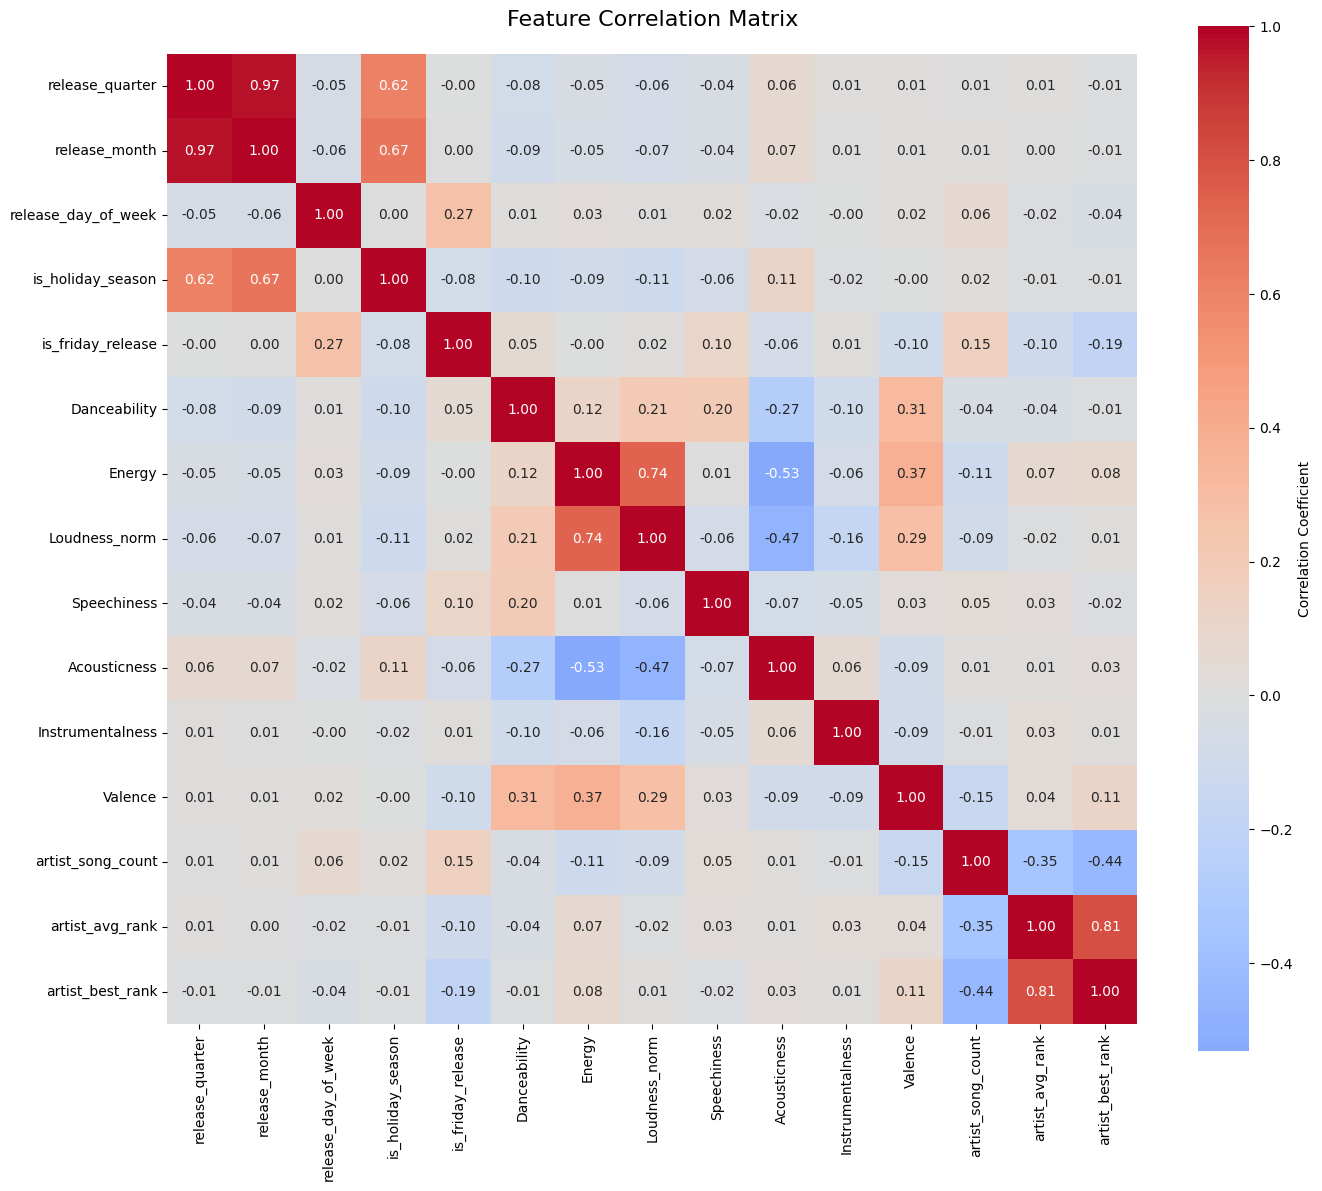

In [718]:
def plot_correlation_matrix(corr_matrix):
    """Create heatmap of correlations"""
    
    plt.figure(figsize=(14, 12))
    
    # Create heatmap
    sns.heatmap(corr_matrix, 
                annot=True,           # Show correlation values
                cmap='coolwarm',     # Color scheme
                center=0,            # Center at 0
                fmt='.2f',           # Format to 2 decimals
                square=True,           # Make cells square
                cbar_kws={'label': 'Correlation Coefficient'})
    
    plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(correlation_matrix)


In [719]:
def fix_threshold_optimization():
    """Find optimal threshold to maximize F1"""
    
    print("🎯 FIX 1: THRESHOLD OPTIMIZATION")
    print("=" * 60)
    
    # Use your best model (Random Forest)
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import StandardScaler
    
    # Simple pipeline without SMOTE for threshold testing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(sorted_X)
    X_test_scaled = scaler.transform(sorted_X)
    
    rf = models['XGBoost']
    rf.fit(X_train_scaled, sorted_y)
    
    # Get probabilities on test set
    y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]
    
    # Test different thresholds
    from sklearn.metrics import f1_score, precision_score, recall_score
    
    thresholds = np.arange(0.1, 0.9, 0.05)
    results = []
    
    print("Testing different thresholds:")
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        f1 = f1_score(sorted_y, y_pred)
        precision = precision_score(sorted_y, y_pred)
        recall = recall_score(sorted_y, y_pred)
        accuracy = (y_pred == sorted_y).mean()
        
        results.append({
            'Threshold': threshold,
            'F1': f1,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'Predictions': y_pred.sum(),
            'Popular_Predictions': y_pred.sum() / len(y_pred)
        })
        
        print(f"  Threshold {threshold:.2f}: F1={f1:.3f}, Precision={precision:.3f}, Recall={recall:.3f}")
    
    # Find best threshold
    results_df = pd.DataFrame(results)
    best_threshold = results_df.loc[results_df['F1'].idxmax()]
    
    print(f"\n🎉 OPTIMAL THRESHOLD: {best_threshold['Threshold']:.2f}")
    print(f"Best F1 Score: {best_threshold['F1']:.3f}")
    print(f"Improvement over 0.5: {best_threshold['F1'] - 0.51:.3f}")
    
    return best_threshold, results_df

optimal_threshold, threshold_analysis = fix_threshold_optimization()


🎯 FIX 1: THRESHOLD OPTIMIZATION
Testing different thresholds:
  Threshold 0.10: F1=0.651, Precision=0.482, Recall=1.000
  Threshold 0.15: F1=0.714, Precision=0.556, Recall=0.998
  Threshold 0.20: F1=0.771, Precision=0.630, Recall=0.995
  Threshold 0.25: F1=0.819, Precision=0.700, Recall=0.988
  Threshold 0.30: F1=0.854, Precision=0.760, Recall=0.973
  Threshold 0.35: F1=0.887, Precision=0.827, Recall=0.958
  Threshold 0.40: F1=0.905, Precision=0.880, Recall=0.933
  Threshold 0.45: F1=0.911, Precision=0.923, Recall=0.899
  Threshold 0.50: F1=0.900, Precision=0.953, Recall=0.853
  Threshold 0.55: F1=0.876, Precision=0.972, Recall=0.797
  Threshold 0.60: F1=0.834, Precision=0.989, Recall=0.722
  Threshold 0.65: F1=0.779, Precision=0.998, Recall=0.639
  Threshold 0.70: F1=0.710, Precision=0.999, Recall=0.551
  Threshold 0.75: F1=0.612, Precision=1.000, Recall=0.441
  Threshold 0.80: F1=0.499, Precision=1.000, Recall=0.333
  Threshold 0.85: F1=0.379, Precision=1.000, Recall=0.234

🎉 OPTIMAL

In [ ]:
print('hello world')

print('hello world 5')

print('hello world 3')
print('hello world 10')